In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
import os

In [2]:
Images='/content/anime-faces'

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(Images, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

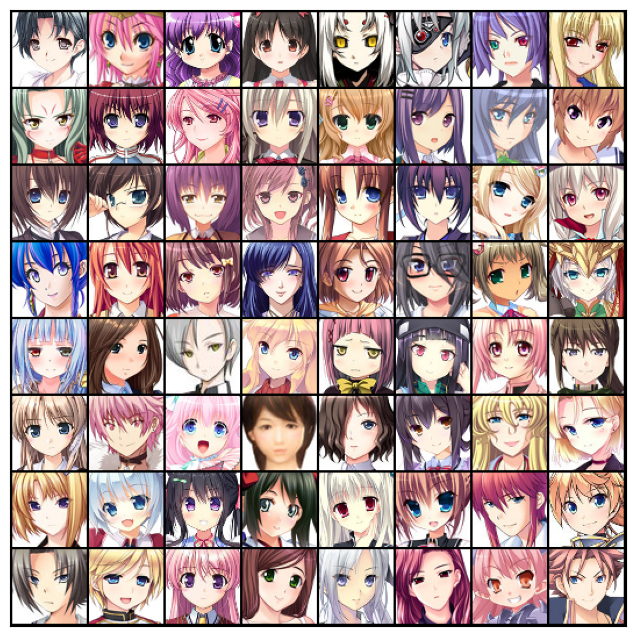

In [7]:
show_batch(train_dl)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [12]:
discriminator = to_device(discriminator, device)

In [13]:
latent_size = 150

In [14]:
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


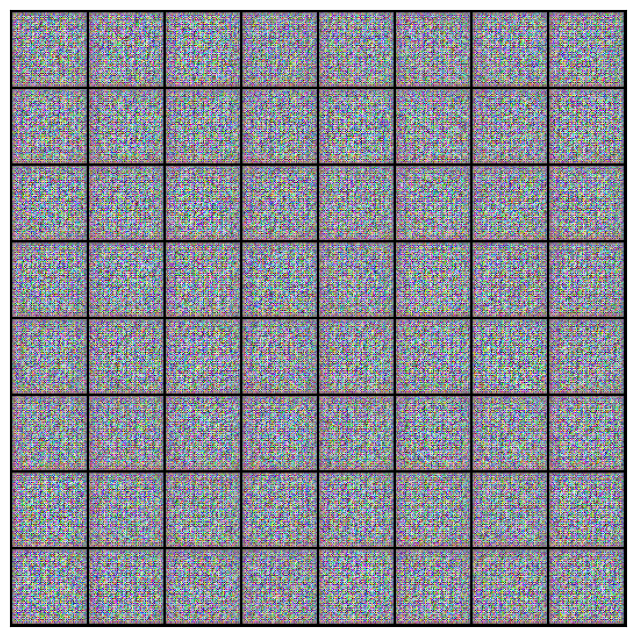

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator, device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [19]:
Save_Images = 'Generated_Images'
os.makedirs(Save_Images, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(Save_Images, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [22]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [23]:
lr = 0.0002
epochs = 50

In [24]:
History = fit(epochs, lr)

  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 4.5342, loss_d: 0.8434, real_score: 0.8091, fake_score: 0.4262
Saving image-0001.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.6082, loss_d: 0.3230, real_score: 0.7748, fake_score: 0.0337
Saving image-0002.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 7.8136, loss_d: 0.9829, real_score: 0.9503, fake_score: 0.5634
Saving image-0003.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 7.1473, loss_d: 0.8149, real_score: 0.9844, fake_score: 0.5020
Saving image-0004.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 5.1566, loss_d: 0.3286, real_score: 0.8583, fake_score: 0.1340
Saving image-0005.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.6344, loss_d: 0.2468, real_score: 0.9023, fake_score: 0.1185
Saving image-0006.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 5.8032, loss_d: 0.3791, real_score: 0.9514, fake_score: 0.2376
Saving image-0007.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 9.6216, loss_d: 0.5489, real_score: 0.9968, fake_score: 0.3534
Saving image-0008.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.8156, loss_d: 0.2473, real_score: 0.9158, fake_score: 0.1271
Saving image-0009.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.5808, loss_d: 0.1620, real_score: 0.9140, fake_score: 0.0571
Saving image-0010.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.6251, loss_d: 0.1578, real_score: 0.9816, fake_score: 0.1128
Saving image-0011.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 5.7685, loss_d: 0.2855, real_score: 0.9351, fake_score: 0.1698
Saving image-0012.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.5756, loss_d: 0.1845, real_score: 0.8647, fake_score: 0.0151
Saving image-0013.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 7.8082, loss_d: 0.3749, real_score: 0.7375, fake_score: 0.0006
Saving image-0014.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 6.2647, loss_d: 0.3695, real_score: 0.9292, fake_score: 0.2248
Saving image-0015.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.1790, loss_d: 0.2191, real_score: 0.9495, fake_score: 0.1378
Saving image-0016.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.2574, loss_d: 0.1333, real_score: 0.9224, fake_score: 0.0422
Saving image-0017.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.2401, loss_d: 0.1293, real_score: 0.9268, fake_score: 0.0469
Saving image-0018.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.4518, loss_d: 0.0967, real_score: 0.9368, fake_score: 0.0258
Saving image-0019.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 6.1392, loss_d: 0.2752, real_score: 0.9748, fake_score: 0.1953
Saving image-0020.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 4.2018, loss_d: 0.1325, real_score: 0.9214, fake_score: 0.0410
Saving image-0021.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.5194, loss_d: 0.2095, real_score: 0.9349, fake_score: 0.1177
Saving image-0022.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.3473, loss_d: 0.1714, real_score: 0.9244, fake_score: 0.0736
Saving image-0023.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 5.2647, loss_d: 0.2774, real_score: 0.9602, fake_score: 0.1861
Saving image-0024.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 2.4703, loss_d: 1.5958, real_score: 0.3067, fake_score: 0.0002
Saving image-0025.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.6436, loss_d: 0.1070, real_score: 0.9594, fake_score: 0.0578
Saving image-0026.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 5.3509, loss_d: 0.3132, real_score: 0.9988, fake_score: 0.2360
Saving image-0027.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 4.3657, loss_d: 0.1009, real_score: 0.9571, fake_score: 0.0504
Saving image-0028.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 5.0964, loss_d: 0.1322, real_score: 0.9576, fake_score: 0.0722
Saving image-0029.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.0222, loss_d: 0.1553, real_score: 0.9304, fake_score: 0.0691
Saving image-0030.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.5116, loss_d: 0.1124, real_score: 0.9491, fake_score: 0.0521
Saving image-0031.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.7104, loss_d: 0.2088, real_score: 0.9728, fake_score: 0.1439
Saving image-0032.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 6.7901, loss_d: 0.1869, real_score: 0.9885, fake_score: 0.1402
Saving image-0033.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 5.0944, loss_d: 0.1467, real_score: 0.9851, fake_score: 0.1089
Saving image-0034.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.8275, loss_d: 0.2375, real_score: 0.8628, fake_score: 0.0641
Saving image-0035.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 5.2835, loss_d: 0.1084, real_score: 0.9366, fake_score: 0.0315
Saving image-0036.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.0633, loss_d: 0.1121, real_score: 0.9683, fake_score: 0.0689
Saving image-0037.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.5095, loss_d: 0.0419, real_score: 0.9794, fake_score: 0.0202
Saving image-0038.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.9348, loss_d: 0.1637, real_score: 0.9159, fake_score: 0.0608
Saving image-0039.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 5.1874, loss_d: 0.0500, real_score: 0.9676, fake_score: 0.0157
Saving image-0040.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.6359, loss_d: 0.0956, real_score: 0.9315, fake_score: 0.0193
Saving image-0041.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.0024, loss_d: 0.2659, real_score: 0.8013, fake_score: 0.0049
Saving image-0042.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.4133, loss_d: 0.0335, real_score: 0.9892, fake_score: 0.0218
Saving image-0043.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.6057, loss_d: 0.1156, real_score: 0.9492, fake_score: 0.0552
Saving image-0044.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 5.1383, loss_d: 0.0366, real_score: 0.9840, fake_score: 0.0192
Saving image-0045.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.4581, loss_d: 0.1223, real_score: 0.9352, fake_score: 0.0463
Saving image-0046.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.7299, loss_d: 0.0575, real_score: 0.9698, fake_score: 0.0241
Saving image-0047.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 4.7712, loss_d: 0.0520, real_score: 0.9689, fake_score: 0.0185
Saving image-0048.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 5.4535, loss_d: 0.0461, real_score: 0.9857, fake_score: 0.0296
Saving image-0049.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.9848, loss_d: 0.0744, real_score: 0.9817, fake_score: 0.0496
Saving image-0050.png


In [25]:
from IPython.display import Image

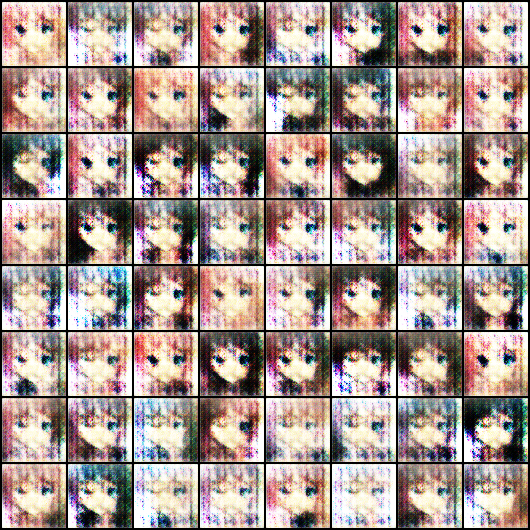

In [26]:
Image('/content/Generated_Images/image-0001.png')

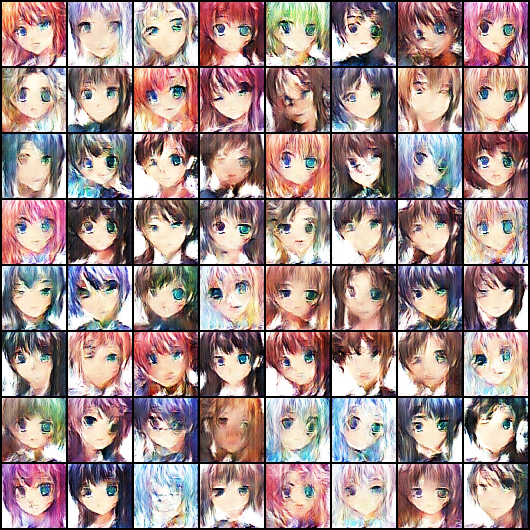

In [27]:
Image('/content/Generated_Images/image-0010.png')

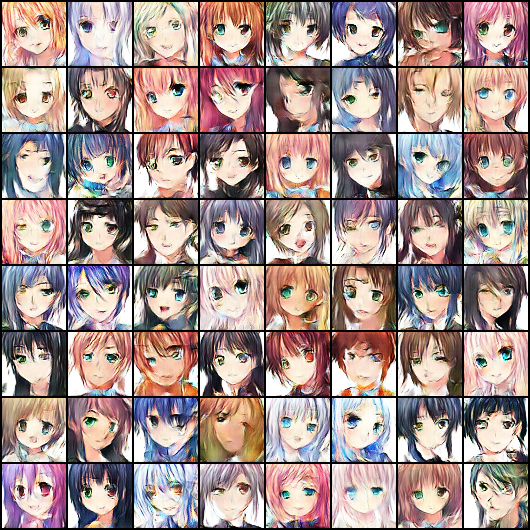

In [28]:
Image('/content/Generated_Images/image-0020.png')

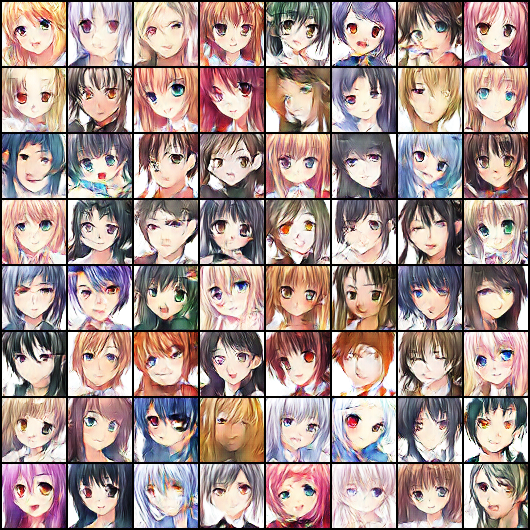

In [29]:
Image('/content/Generated_Images/image-0030.png')

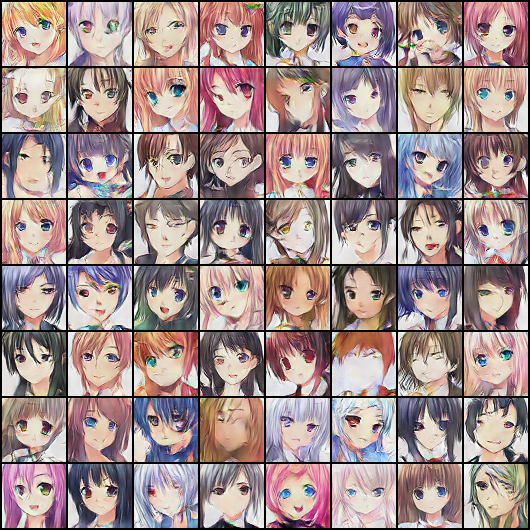

In [30]:
Image('/content/Generated_Images/image-0040.png')

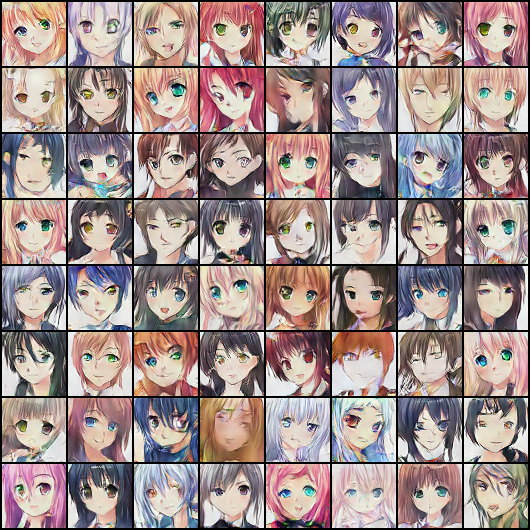

In [31]:
Image('/content/Generated_Images/image-0045.png')

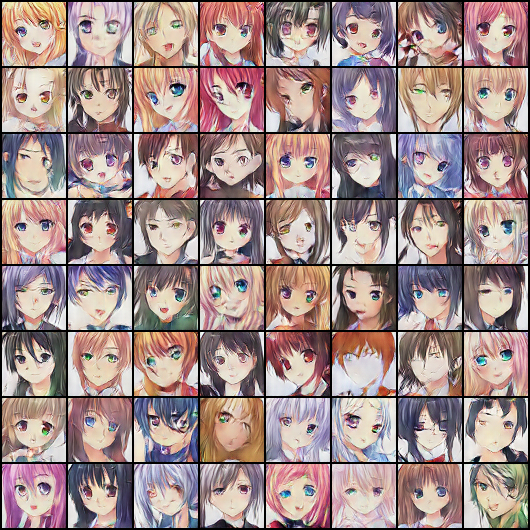

In [32]:
Image('/content/Generated_Images/image-0050.png')